In [1]:
import os
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.windows import Window
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import gc

In [2]:
def find_all_jp2_files(root_folder):
    """
    Рекурсивно знаходить усі файли .jp2 у заданій папці.
    
    :param root_folder: Коренева папка для пошуку файлів.
    :return: Список шляхів до всіх знайдених файлів .jp2.
    """
    jp2_files = []
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower().endswith('.jp2'):
                jp2_files.append(os.path.join(dirpath, file))
    return jp2_files

In [3]:
def reproject_shapes_if_needed(gdf, target_crs):
    """
    Перевіряє CRS та перетворює його у потрібну систему координат, якщо необхідно.
    
    :param gdf: GeoDataFrame із мітками.
    :param target_crs: Бажана система координат (CRS).
    :return: GeoDataFrame із оновленим CRS.
    """
    if gdf.crs != target_crs:
        print(f"Перетворення CRS з {gdf.crs} на {target_crs}...")
        gdf = gdf.to_crs(target_crs)
        print("Перетворення завершено.")
    else:
        print("CRS вже збігається із цільовою.")
    return gdf

In [4]:
def create_mask_for_all_images(jp2_files, geojson_path, output_folder):
    """
    Створює маски для всіх зображень .jp2 на основі міток із файлу .geojson.
    
    :param jp2_files: Список шляхів до файлів .jp2.
    :param geojson_path: Шлях до файлу .geojson із мітками.
    :param output_folder: Папка для збереження масок.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Завантаження міток із GeoJSON
    gdf = gpd.read_file(geojson_path)
    target_crs = None

    for jp2_file in jp2_files:
        output_mask_path = os.path.join(output_folder, os.path.basename(jp2_file).replace('.jp2', '_mask.tif'))

        with rasterio.open(jp2_file) as src:
            if target_crs is None:
                target_crs = src.crs

            # Перетворення CRS міток, якщо необхідно
            gdf = reproject_shapes_if_needed(gdf, target_crs)

            # Створення маски
            shapes = [mapping(geom) for geom in gdf.geometry]
            out_image, out_transform = mask(src, shapes, crop=True)

            out_meta = src.meta.copy()
            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})

            with rasterio.open(output_mask_path, "w", **out_meta) as dest:
                dest.write(out_image)
        
        print(f"Маску створено: {output_mask_path}")

In [5]:
# Шлях до кореневої папки із зображеннями
root_folder = r"D:\CV_Project_data"  # Заміни на свій шлях до папки з .jp2 файлами
# Шлях до файлу .geojson із мітками
geojson_path = r"D:\CV_Project_data\deforestation_labels.geojson"  # Шлях до знайденого .geojson файлу
# Папка для збереження масок
output_folder = r"D:\Test_task_NER_CV\CV_Project\output_masks"  # Шлях для збереження масок

# Знаходимо всі файли .jp2
jp2_files = find_all_jp2_files(root_folder)

# Створюємо маски для всіх знайдених файлів
create_mask_for_all_images(jp2_files, geojson_path, output_folder)

Перетворення CRS з EPSG:4326 на EPSG:32636...
Перетворення завершено.
Маску створено: C:\Users\marko\Test_task_NER_CV\CV_Project\output_masks\T36UYA_20160212T084052_B01_mask.tif
CRS вже збігається із цільовою.
Маску створено: C:\Users\marko\Test_task_NER_CV\CV_Project\output_masks\T36UYA_20160212T084052_B02_mask.tif
CRS вже збігається із цільовою.
Маску створено: C:\Users\marko\Test_task_NER_CV\CV_Project\output_masks\T36UYA_20160212T084052_B03_mask.tif
CRS вже збігається із цільовою.
Маску створено: C:\Users\marko\Test_task_NER_CV\CV_Project\output_masks\T36UYA_20160212T084052_B04_mask.tif
CRS вже збігається із цільовою.
Маску створено: C:\Users\marko\Test_task_NER_CV\CV_Project\output_masks\T36UYA_20160212T084052_B05_mask.tif
CRS вже збігається із цільовою.
Маску створено: C:\Users\marko\Test_task_NER_CV\CV_Project\output_masks\T36UYA_20160212T084052_B06_mask.tif
CRS вже збігається із цільовою.
Маску створено: C:\Users\marko\Test_task_NER_CV\CV_Project\output_masks\T36UYA_20160212T08

In [5]:
# Функція для рекурсивного пошуку файлів
def find_all_files_recursive(folder, extension):
    """
    Рекурсивно знаходить усі файли із заданим розширенням у папці та підпапках.
    
    :param folder: Коренева папка для пошуку файлів.
    :param extension: Розширення файлів (наприклад, '.jp2' або '.tif').
    :return: Список шляхів до всіх знайдених файлів із вказаним розширенням.
    """
    files = []
    for dirpath, _, filenames in os.walk(folder):
        for file in filenames:
            if file.lower().endswith(extension):
                files.append(os.path.join(dirpath, file))
    return sorted(files)

# Шляхи до папок із зображеннями та масками
image_folder = r"D:\CV_Project_data"  # Заміни на свою папку із зображеннями
mask_folder = r"D:\Test_task_NER_CV\CV_Project\output_masks"  # Папка із масками

# Знаходження всіх файлів із розширенням .jp2 та .tif
image_files = find_all_files_recursive(image_folder, '.jp2')
mask_files = find_all_files_recursive(mask_folder, '.tif')

# Папки для збереження тайлів
output_image_folder = r"D:\Test_task_NER_CV\CV_Project\tiles\images"
output_mask_folder = r"D:\Test_task_NER_CV\CV_Project\tiles\masks"

In [6]:
def group_files_by_channels_recursive(image_folder, extension=".jp2"):
    """
    Рекурсивно групує файли за кількістю каналів у папці та підпапках.
    
    :param image_folder: Шлях до кореневої папки із зображеннями.
    :param extension: Розширення файлів (за замовчуванням .jp2).
    :return: Словник, де ключ — кількість каналів, а значення — список файлів.
    """
    grouped_files = {}

    for dirpath, _, filenames in os.walk(image_folder):
        for file in filenames:
            if file.lower().endswith(extension):
                image_file = os.path.join(dirpath, file)
                with rasterio.open(image_file) as src:
                    channel_count = src.count
                    if channel_count not in grouped_files:
                        grouped_files[channel_count] = []
                    grouped_files[channel_count].append(image_file)
    
    return grouped_files

# Групування файлів за каналами
image_folder = r"D:\CV_Project_data"  # Вкажіть вашу папку із зображеннями
grouped_files = group_files_by_channels_recursive(image_folder)

# Виведення результатів
for channel_count, files in grouped_files.items():
    print(f"Кількість каналів: {channel_count}, Кількість файлів: {len(files)}")

Кількість каналів: 1, Кількість файлів: 650
Кількість каналів: 3, Кількість файлів: 100


In [7]:
def match_image_and_mask_files_by_suffix(image_files, mask_files):
    """
    Підбирає відповідні пари файлів із зображеннями та масками за суфіксом (наприклад, B01, B02).
    
    :param image_files: Список файлів із зображеннями.
    :param mask_files: Список файлів із масками.
    :return: Список пар (шлях до зображення, шлях до маски).
    """
    matched_pairs = []
    
    # Створюємо словник для швидкого пошуку масок за суфіксом
    mask_dict = {os.path.basename(mask).split('_')[-2]: mask for mask in mask_files}
    
    for img in image_files:
        img_suffix = os.path.basename(img).split('_')[-1].split('.')[0]  # Беремо суфікс файлу зображення
        if img_suffix in mask_dict:
            matched_pairs.append((img, mask_dict[img_suffix]))
    
    print(f"Знайдено {len(matched_pairs)} відповідних пар файлів")
    return matched_pairs

In [8]:
# Знаходимо відповідні пари файлів
matched_pairs = match_image_and_mask_files_by_suffix(image_files, mask_files)


Знайдено 750 відповідних пар файлів


In [9]:
def clear_folder(folder_path):
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Видаляє файли
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Видаляє підпапки
            except Exception as e:
                print(f"Помилка при видаленні {file_path}: {e}")

In [10]:
clear_folder(output_image_folder)
clear_folder(output_mask_folder)

In [11]:
def group_files_by_channels(image_folder, extension=".jp2"):
    """
    Групує файли в папці за кількістю каналів.
    
    :param image_folder: Шлях до папки із зображеннями.
    :param extension: Розширення файлів (за замовчуванням .jp2).
    :return: Словник, де ключі — кількість каналів, а значення — списки шляхів до файлів.
    """
    grouped_files = {}
    for dirpath, _, filenames in os.walk(image_folder):
        for file in filenames:
            if file.lower().endswith(extension):
                image_file = os.path.join(dirpath, file)
                try:
                    with rasterio.open(image_file) as src:
                        channel_count = src.count
                        if channel_count not in grouped_files:
                            grouped_files[channel_count] = []
                        grouped_files[channel_count].append(image_file)
                except Exception as e:
                    print(f"Помилка під час відкриття {image_file}: {e}")
    return grouped_files

In [12]:
def process_grouped_files(grouped_files, output_image_folder, output_mask_folder, tile_size=1024, batch_size=6):
    """
    Обробляє файли з різними кількостями каналів.
    
    :param grouped_files: Словник файлів, згрупованих за кількістю каналів.
    :param output_image_folder: Папка для збереження тайлів зображень.
    :param output_mask_folder: Папка для збереження тайлів масок.
    :param tile_size: Розмір тайлів.
    :param batch_size: Кількість файлів у партії.
    """
    for channel_count, files in grouped_files.items():
        print(f"Обробка файлів з {channel_count} каналами. Кількість файлів: {len(files)}")
        # Поділ на батчі
        for start_idx in range(0, len(files), batch_size):
            end_idx = min(start_idx + batch_size, len(files))
            batch_files = files[start_idx:end_idx]
            print(f"  Обробка файлів {start_idx + 1} до {end_idx} із {len(files)}")
            
            for img_path in batch_files:
                with rasterio.open(img_path) as src_img:
                    img_width, img_height = src_img.width, src_img.height
                    
                    for y in range(0, img_height, tile_size):
                        for x in range(0, img_width, tile_size):
                            window = Window(x, y, tile_size, tile_size)
                            img_tile = src_img.read(window=window)
                            
                            if img_tile.size == 0:  # Пропустити пусті тайли
                                continue
                            
                            # Збереження тайлів
                            tile_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_{x}_{y}.tif"
                            img_tile_path = os.path.join(output_image_folder, tile_name)

                            out_meta = src_img.meta.copy()
                            out_meta.update({
                                "driver": "GTiff",
                                "height": tile_size,
                                "width": tile_size,
                                "transform": rasterio.windows.transform(window, src_img.transform)
                            })

                            with rasterio.open(img_tile_path, "w", **out_meta) as dest_img:
                                dest_img.write(img_tile)

                            print(f"  Тайл збережено: {img_tile_path}")

    print("Усі файли оброблено успішно.")

In [13]:
# Використання
image_folder = r"D:\CV_Project_data"  # Папка із зображеннями
output_image_folder = r"D:\CV_Project\output\images"
output_mask_folder = r"D:\CV_Project\output\masks"

In [14]:
# Крок 1: Групування файлів
grouped_files = group_files_by_channels(image_folder)


In [15]:
# Крок 2: Обробка груп
process_grouped_files(grouped_files, output_image_folder, output_mask_folder, tile_size=1024, batch_size=6)

Обробка файлів з 1 каналами. Кількість файлів: 650
  Обробка файлів 1 до 6 із 650


RasterioIOError: Attempt to create new tiff file 'D:/CV_Project/output/images/T36UYA_20160212T084052_B01_0_0.tif' failed: No such file or directory

In [10]:
def split_image_and_mask_into_tiles_batch(matched_pairs, output_image_folder, output_mask_folder, tile_size=1024, batch_size=4):
    """
    Розбиває великі зображення та маски на тайли фіксованого розміру, зберігаючи всі канали.
    
    :param matched_pairs: Список пар (шлях до зображення, шлях до маски).
    :param output_image_folder: Папка для збереження тайлів зображень.
    :param output_mask_folder: Папка для збереження тайлів масок.
    :param tile_size: Розмір тайлів.
    :param batch_size: Кількість файлів для обробки в одній партії.
    """
    # Створення папок для збереження
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_mask_folder, exist_ok=True)

    total_files = len(matched_pairs)
    for start_idx in range(0, total_files, batch_size):
        end_idx = min(start_idx + batch_size, total_files)
        print(f"Обробка файлів {start_idx + 1} до {end_idx} із {total_files}")
        
        batch_pairs = matched_pairs[start_idx:end_idx]
        
        for img_path, mask_path in batch_pairs:
            print(f"  Обробляється файл: {img_path}")
            with rasterio.open(img_path) as src_img, rasterio.open(mask_path) as src_mask:
                img_width, img_height = src_img.width, src_img.height

                for y in range(0, img_height, tile_size):
                    for x in range(0, img_width, tile_size):
                        window = Window(x, y, tile_size, tile_size)
                        
                        # Читання тайла зображення
                        img_tile = src_img.read(window=window)
                        
                        # Читання тайла маски
                        mask_tile = src_mask.read(window=window)

                        # Пропускаємо пусті тайли
                        if mask_tile.size == 0 or img_tile.size == 0:
                            continue
                        
                        # Налаштування метаінформації для тайлів
                        out_meta = src_img.meta.copy()
                        out_meta.update({
                            "driver": "GTiff",
                            "height": tile_size,
                            "width": tile_size,
                            "transform": rasterio.windows.transform(window, src_img.transform),
                            "compress": "LZW"  # Стиснення без втрат
                        })

                        # Формування шляхів для збереження тайлів
                        tile_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_{x}_{y}.tif"
                        img_tile_path = os.path.join(output_image_folder, tile_name)
                        mask_tile_path = os.path.join(output_mask_folder, tile_name)

                        # Збереження тайла зображення
                        with rasterio.open(img_tile_path, "w", **out_meta) as dest_img:
                            dest_img.write(img_tile)

                        # Збереження тайла маски
                        with rasterio.open(mask_tile_path, "w", **out_meta) as dest_mask:
                            dest_mask.write(mask_tile)

                        print(f"  Тайли збережено: {img_tile_path}, {mask_tile_path}")

                        # Очищення пам'яті
                        del img_tile, mask_tile
                        gc.collect()

    print("Усі тайли створено успішно")

In [ ]:
# Запускаємо функцію для створення тайлів із використанням знайдених пар
split_image_and_mask_into_tiles_batch(matched_pairs, output_image_folder, output_mask_folder, tile_size=1024, batch_size=4)

Обробка файлів 1 до 4 із 750
  Обробляється файл: D:\CV_Project_data\S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510\S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE\GRANULE\L1C_T36UYA_A003350_20160212T084510\IMG_DATA\T36UYA_20160212T084052_B01.jp2


In [8]:
def split_dataset(image_folder, mask_folder, output_base_folder, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Розділяє тайли зображень та масок на три частини: train, val, test.
    
    :param image_folder: Папка із тайлами зображень.
    :param mask_folder: Папка із тайлами масок.
    :param output_base_folder: Базова папка для збереження розділених даних.
    :param train_ratio: Частка даних для тренувального набору (за замовчуванням 80%).
    :param val_ratio: Частка даних для валідаційного набору (за замовчуванням 10%).
    :param test_ratio: Частка даних для тестового набору (за замовчуванням 10%).
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Сума співвідношень має дорівнювати 1.0"

    # Отримуємо список файлів із зображеннями та масками
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.tif')])
    
    # Перевірка, що кількість зображень і масок однакова
    assert len(image_files) == len(mask_files), "Кількість зображень і масок повинна збігатися"

    # Перемішуємо список файлів для випадкового розділення
    combined = list(zip(image_files, mask_files))
    random.shuffle(combined)
    image_files, mask_files = zip(*combined)

    total_files = len(image_files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    # Розділяємо файли на train, val, test
    train_files = combined[:train_count]
    val_files = combined[train_count:train_count + val_count]
    test_files = combined[train_count + val_count:]

    # Функція для копіювання файлів у відповідні папки
    def copy_files(file_list, dest_image_folder, dest_mask_folder):
        if not os.path.exists(dest_image_folder):
            os.makedirs(dest_image_folder)
        if not os.path.exists(dest_mask_folder):
            os.makedirs(dest_mask_folder)
        
        for img_file, mask_file in file_list:
            shutil.copy(os.path.join(image_folder, img_file), dest_image_folder)
            shutil.copy(os.path.join(mask_folder, mask_file), dest_mask_folder)

    # Копіюємо файли у відповідні папки
    copy_files(train_files, os.path.join(output_base_folder, 'train', 'images'), os.path.join(output_base_folder, 'train', 'masks'))
    copy_files(val_files, os.path.join(output_base_folder, 'val', 'images'), os.path.join(output_base_folder, 'val', 'masks'))
    copy_files(test_files, os.path.join(output_base_folder, 'test', 'images'), os.path.join(output_base_folder, 'test', 'masks'))

    print(f"Розділення завершено: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test файлів")

# Шляхи до папок із тайлами
image_folder = r"D:\Test_task_NER_CV\CV_Project\tiles\images"
mask_folder = r"D:\Test_task_NER_CV\CV_Project\tiles\masks"
output_base_folder = r"D:\Test_task_NER_CV\CV_Project\dataset"

# Викликаємо функцію для розділення
split_dataset(image_folder, mask_folder, output_base_folder, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

Розділення завершено: 42360 train, 5295 val, 5296 test файлів


In [16]:
def data_generator(image_folder, mask_folder, batch_size=16, target_size=(512, 512)):
    """
    Генерує батчі даних із зображень і масок для тренування моделі.
    
    :param image_folder: Папка із зображеннями.
    :param mask_folder: Папка із масками.
    :param batch_size: Розмір батча.
    :param target_size: Розмір, до якого будуть масштабовані зображення та маски.
    :return: Батч із зображень та відповідних масок.
    """
    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))
    
    while True:  # Безкінечний цикл для генерації даних
        for i in range(0, len(image_files), batch_size):
            batch_images = image_files[i:i + batch_size]
            batch_masks = mask_files[i:i + batch_size]

            images = []
            masks = []

            for img_file, mask_file in zip(batch_images, batch_masks):
                # Завантаження та перетворення зображення
                img_path = os.path.join(image_folder, img_file)
                img = load_img(img_path, target_size=target_size)
                img = img_to_array(img)
                
                # Нормалізація з урахуванням максимального значення
                img = img / img.max()  # Поділ на максимальне значення пікселів
                
                images.append(img)

                # Завантаження та перетворення маски
                mask_path = os.path.join(mask_folder, mask_file)
                mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")
                mask = img_to_array(mask) / 255.0  # Маски можна залишити з нормалізацією на 255
                masks.append(mask)

            yield np.array(images), np.array(masks)

In [17]:
images, masks = next(train_generator)

print("Зображення:")
print("Мінімальне значення:", images.min())
print("Максимальне значення:", images.max())
print("Середнє значення:", images.mean())

Зображення:
Мінімальне значення: 1.0
Максимальне значення: 1.0
Середнє значення: 1.0


In [9]:
# Шляхи до папок train, val, test
train_image_folder = r"D:\Test_task_NER_CV\CV_Project\dataset\train\images"
train_mask_folder = r"D:\Test_task_NER_CV\CV_Project\dataset\train\masks"

val_image_folder = r"D:\Test_task_NER_CV\CV_Project\dataset\val\images"
val_mask_folder = r"D:\Test_task_NER_CV\CV_Project\dataset\val\masks"

# Створення генераторів для train і val наборів
train_generator = data_generator(train_image_folder, train_mask_folder, batch_size=16)
val_generator = data_generator(val_image_folder, val_mask_folder, batch_size=16)

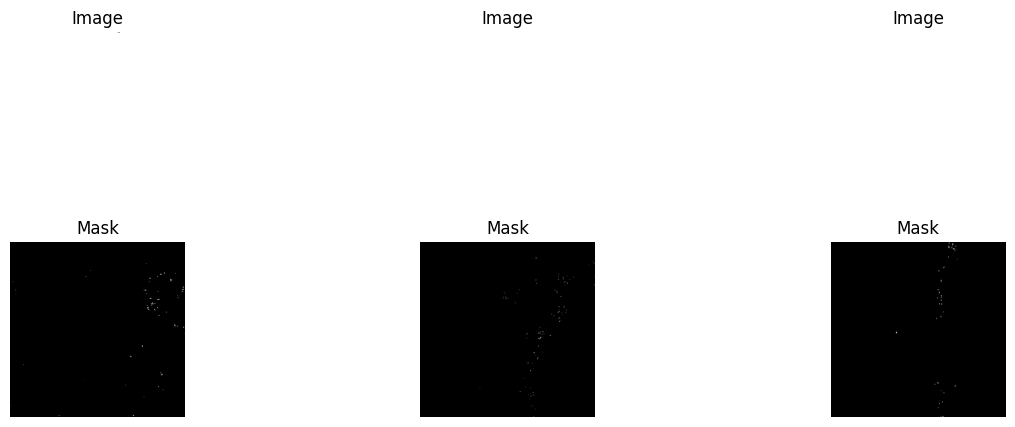

In [10]:
# Функція для відображення прикладів зображень і масок із генератора
def visualize_generator_output(generator, num_samples=3):
    """
    Візуалізує кілька прикладів із генератора даних.
    
    :param generator: Генератор даних.
    :param num_samples: Кількість прикладів для відображення.
    """
    images, masks = next(generator)  # Отримуємо один батч із генератора

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])  # Відображаємо зображення
        plt.axis('off')
        plt.title("Image")

        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Відображаємо маску
        plt.axis('off')
        plt.title("Mask")
    
    plt.show()

# Візуалізуємо приклади із тренувального генератора
visualize_generator_output(train_generator)

In [12]:
# Отримання одного батчу із генератора
images, masks = next(train_generator)  # Використовуй train_generator або val_generator

# Виведення мінімального, максимального та середнього значень у зображеннях
print("Зображення:")
print("Мінімальне значення:", images.min())
print("Максимальне значення:", images.max())
print("Середнє значення:", images.mean())

# Виведення мінімального, максимального та середнього значень у масках
print("Маски:")
print("Мінімальне значення:", masks.min())
print("Максимальне значення:", masks.max())
print("Середнє значення:", masks.mean())

Зображення:
Мінімальне значення: 0.0
Максимальне значення: 1.0
Середнє значення: 0.9998679
Маски:
Мінімальне значення: 0.0
Максимальне значення: 5.5764704
Середнє значення: 0.00036155104


In [14]:
# Отримання одного батчу із генератора
images, masks = next(train_generator)

# Вибираємо перше зображення з батчу
img = images[0]

# Виведення мінімального, максимального та середнього значень у вибраному зображенні
print("Мінімальне значення оригінального зображення:", img.min())
print("Максимальне значення оригінального зображення:", img.max())
print("Середнє значення оригінального зображення:", img.mean())

Мінімальне значення оригінального зображення: 1.0
Максимальне значення оригінального зображення: 1.0
Середнє значення оригінального зображення: 1.0


In [15]:
# Шлях до одного з вихідних .jp2 файлів
jp2_image_path = r"D:\CV_Project_data\S2B_MSIL1C_20190412T083609_N0207_R064_T36UYA_20190412T122445\S2B_MSIL1C_20190412T083609_N0207_R064_T36UYA_20190412T122445.SAFE\GRANULE\L1C_T36UYA_A010958_20190412T084433\IMG_DATA\T36UYA_20190412T083609_B05.jp2"  # Заміни на реальний шлях

with rasterio.open(jp2_image_path) as src:
    img = src.read(1)  # Читаємо перший канал
    print("Мінімальне значення у вихідному .jp2:", img.min())
    print("Максимальне значення у вихідному .jp2:", img.max())
    print("Середнє значення у вихідному .jp2:", img.mean())

Мінімальне значення у вихідному .jp2: 1
Максимальне значення у вихідному .jp2: 25557
Середнє значення у вихідному .jp2: 1893.1891478794032


In [18]:
# Шлях до одного з тайлів
tile_path = r"D:\Test_task_NER_CV\CV_Project\tiles\images\T36UXA_20180731T083601_B02_1536_1024.tif"  # Заміни на реальний шлях

with rasterio.open(tile_path) as src:
    img = src.read(1)  # Читаємо перший канал
    print("Мінімальне значення тайла:", img.min())
    print("Максимальне значення тайла:", img.max())
    print("Середнє значення тайла:", img.mean())


Мінімальне значення тайла: 879
Максимальне значення тайла: 4843
Середнє значення тайла: 1176.736515045166
